In [1]:
# 导入模块
import Solarclip_test
from Solarclip_test import plot_matrix_with_images,calculate_loss
from Data import Solardataloader_subset
from Model.SolarCLIP import get_model_from_args

import torch
import numpy as np
import matplotlib.pyplot as plt

import os
import torch 
import json
from types import SimpleNamespace

In [2]:
json_path = './configs/args1.json'
load_id = 200

with open(json_path, 'r') as f:
    args = json.load(f)
    args = SimpleNamespace(**args)

for arg in vars(args):
    print(f"{arg:<30}: {getattr(args, arg)}")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

SolarModel = get_model_from_args(args)

checkpoint_path = args.checkpoint_path
checkpoint_path += args.token_type + '/'
for i in range(len(args.modal_list)):
    checkpoint_path += args.modal_list[i] + '_'
    for j in range(len(args.enhance_list[i])):
        checkpoint_path += str(args.enhance_list[i][j]) + '_'
print(checkpoint_path)

if load_id is None:
    load_id = args.epochs
    for i in range(21):
        _ = f'{checkpoint_path}/model/epoch_{i}.pt'
        if os.path.exists(_):
            load_dir = _
    assert load_dir is not None
else:
    load_dir = f'{checkpoint_path}/model/epoch_{load_id}.pt'

print(f'loading model from {load_dir}')
SolarModel.load_state_dict(torch.load(load_dir)['model'])
SolarModel = SolarModel.to(device)


config_dir                    : None
batch_size                    : 400
learning_rate                 : 0.1
epochs                        : 100
test_freq                     : 10
save_freq                     : 2
num_workers                   : 16
embed_dim                     : 512
vision_width                  : 768
image_resolution_mag          : 224
vision_layers_mag             : 12
vision_patch_size_mag         : 32
image_resolution_H            : 224
vision_layers_H               : 12
vision_patch_size_H           : 32
token_type                    : all embedding
modal_list                    : ['magnet', '0094']
enhance_list                  : [['None', 1], ['None', 1]]
image_preprocess              : [224, 0.5, 90]
device                        : cuda:0
checkpoint_path               : /mnt/nas/home/huxing/202407/ctf/SolarCLIP/checkpoints/
/mnt/nas/home/huxing/202407/ctf/SolarCLIP/checkpoints/all embedding/magnet_None_1_0094_None_1_
loading model from /mnt/nas/home/huxing/202

Text(0.5, 1.0, 'Test Acc\n Last 10% mean: 17.81%')

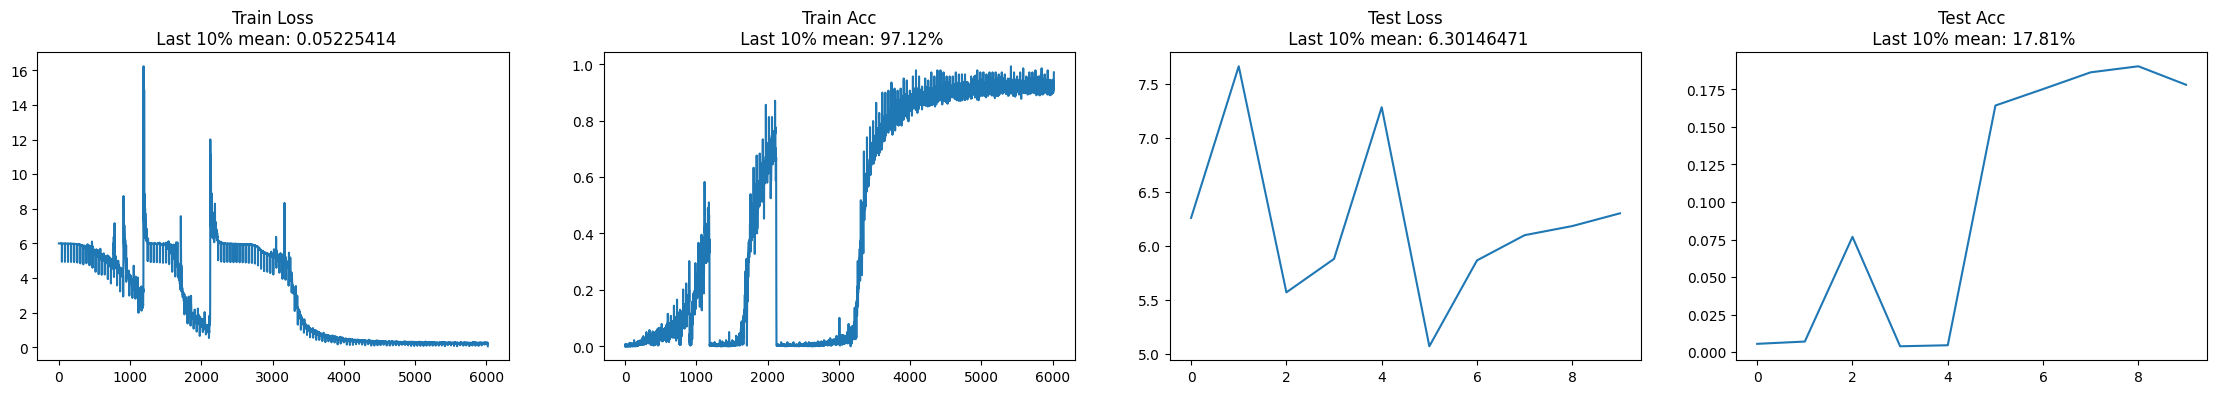

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# log_dir = f'{checkpoint_path}/logger'

log_dir = '/mnt/nas/home/huxing/202407/ctf/SolarCLIP/checkpoints/all embedding/magnet_log1p_224_1_0094_log1p_224_1_/logger'
# load the logger
with open(log_dir + '/logger_train_loss.pkl', 'rb') as f:
    logger_train_loss = pickle.load(f)
with open(log_dir + '/logger_train_loss_inner.pkl', 'rb') as f:
    logger_train_loss_inner = pickle.load(f)
with open(log_dir + '/logger_train_acc.pkl', 'rb') as f:
    logger_train_acc = pickle.load(f)
with open(log_dir + '/logger_val_loss.pkl', 'rb') as f:
    logger_val_loss = pickle.load(f)
with open(log_dir + '/logger_val_loss_inner.pkl', 'rb') as f:
    logger_val_loss_inner = pickle.load(f)
with open(log_dir + '/logger_val_acc.pkl', 'rb') as f:
    logger_val_acc = pickle.load(f)
# with open(log_dir + '/logger_lr.pkl', 'rb') as f:
#     logger_lr = pickle.load(f)

# plot the logger curves

visualization_num = int(len(logger_val_loss)*0.1)


plt.figure(figsize=(28, 4))

plt.subplot(1,4,1)
plt.plot(logger_train_loss)
train_loss_last = np.mean(logger_train_loss[-visualization_num:])
plt.title('Train Loss\n Last 10% mean: {:.8f}'.format(train_loss_last))

plt.subplot(1,4,2)
plt.plot(logger_train_acc)
train_acc_last = np.mean(logger_train_acc[-visualization_num:])
plt.title('Train Acc\n Last 10% mean: {:.2%}'.format(train_acc_last))

# plt.subplot(1,7,3)
# plt.plot(logger_lr)
# train_lr_last = np.mean(logger_lr[-visualization_num:])
# plt.title('Train Acc\n Last 10% mean: {:.2%}'.format(train_lr_last))

# plt.subplot(1,6,3)
# plt.plot(logger_train_loss_inner)
# train_loss_inner_last = np.mean(logger_train_loss_inner[-visualization_num:])

plt.subplot(1,4,3)
plt.plot(logger_val_loss)
test_loss_last = np.mean(logger_val_loss[-visualization_num:])
plt.title('Test Loss\n Last 10% mean: {:.8f}'.format(test_loss_last))

plt.subplot(1,4,4)
plt.plot(logger_val_acc)
test_acc_last = np.mean(logger_val_acc[-visualization_num:])
plt.title('Test Acc\n Last 10% mean: {:.2%}'.format(test_acc_last))

# plt.subplot(1,6,6)
# plt.plot(logger_val_loss_inner)
# test_loss_inner_last = np.mean(logger_val_loss_inner[-visualization_num:])



保存feature

In [3]:
from Data.utils import transfer_date_to_id

mag_feature_list = []
h_feature_list = []
start_date = transfer_date_to_id(2010, 5, 13)
end_date = transfer_date_to_id(2010, 5, 15)
print(start_date,end_date)


val_loader = Solardataloader_subset.get_loader_by_time(load_imgs=False,time_step=24*60,time_interval=[start_date,end_date],modal_list = args.modal_list, enhance_list = [args.image_preprocess[0],0,0], batch_size = 2, shuffle=False, num_workers=args.num_workers)

with torch.no_grad():
    SolarModel = SolarModel.eval()
    for i, data in enumerate(val_loader):
        mag_image = data[:,0,:,:,:] # [batch, channel, height, width]
        h_image = data[:,1,:,:,:]
        mag_image = mag_image.to(device)
        h_image = h_image.to(device)
        mag_features = SolarModel.encode_mag(mag_image)   #shape = [batch_size, length,embed_dim]
        H_features = SolarModel.encode_H(h_image)

        mag_feature_list.append(mag_features)
        h_feature_list.append(H_features)



17280 20160
 magnet has 72889 samples
 0094 has 120206 samples
All modal has 1 samples


In [9]:
print(mag_features.shape)

torch.Size([1, 50, 512])


In [8]:
from Data.utils import save_list

save_list(mag_feature_list, './output/mag_feature_list.pkl')
save_list(h_feature_list, './output/h_feature_list.pkl')

In [34]:
from Data.utils import transfer_date_to_id

acc_list = []
start_date = transfer_date_to_id(2020, 6, 30)
end_date = transfer_date_to_id(2024, 6, 30)

val_loader = Solardataloader_subset.get_loader_by_time(time_step=12*24*60,time_interval=[start_date,end_date],modal_list = args.modal_list, enhance_list = [args.image_preprocess[0],0,0], batch_size = 256, shuffle=False, num_workers=args.num_workers)

with torch.no_grad():
    SolarModel = SolarModel.eval()
    for i, data in enumerate(val_loader):

        # mask = torch.arange(data.size(0)) != 11
        # data = data[mask]

        mag_image = data[:,0,:,:,:] # [batch, channel, height, width]
        h_image = data[:,1,:,:,:]
        data = data.to(device)
        loss, loss_inner, acc, logits_per_mag, inner_cor_matrix = calculate_loss(SolarModel, data, criterion=torch.nn.functional.cross_entropy)
        # print(logits_per_mag_np.shape)

        acc_list.append(acc)

print('evaluate finished')
print('acc mean:', np.mean(acc_list))


acc mean: 0.06451612710952759


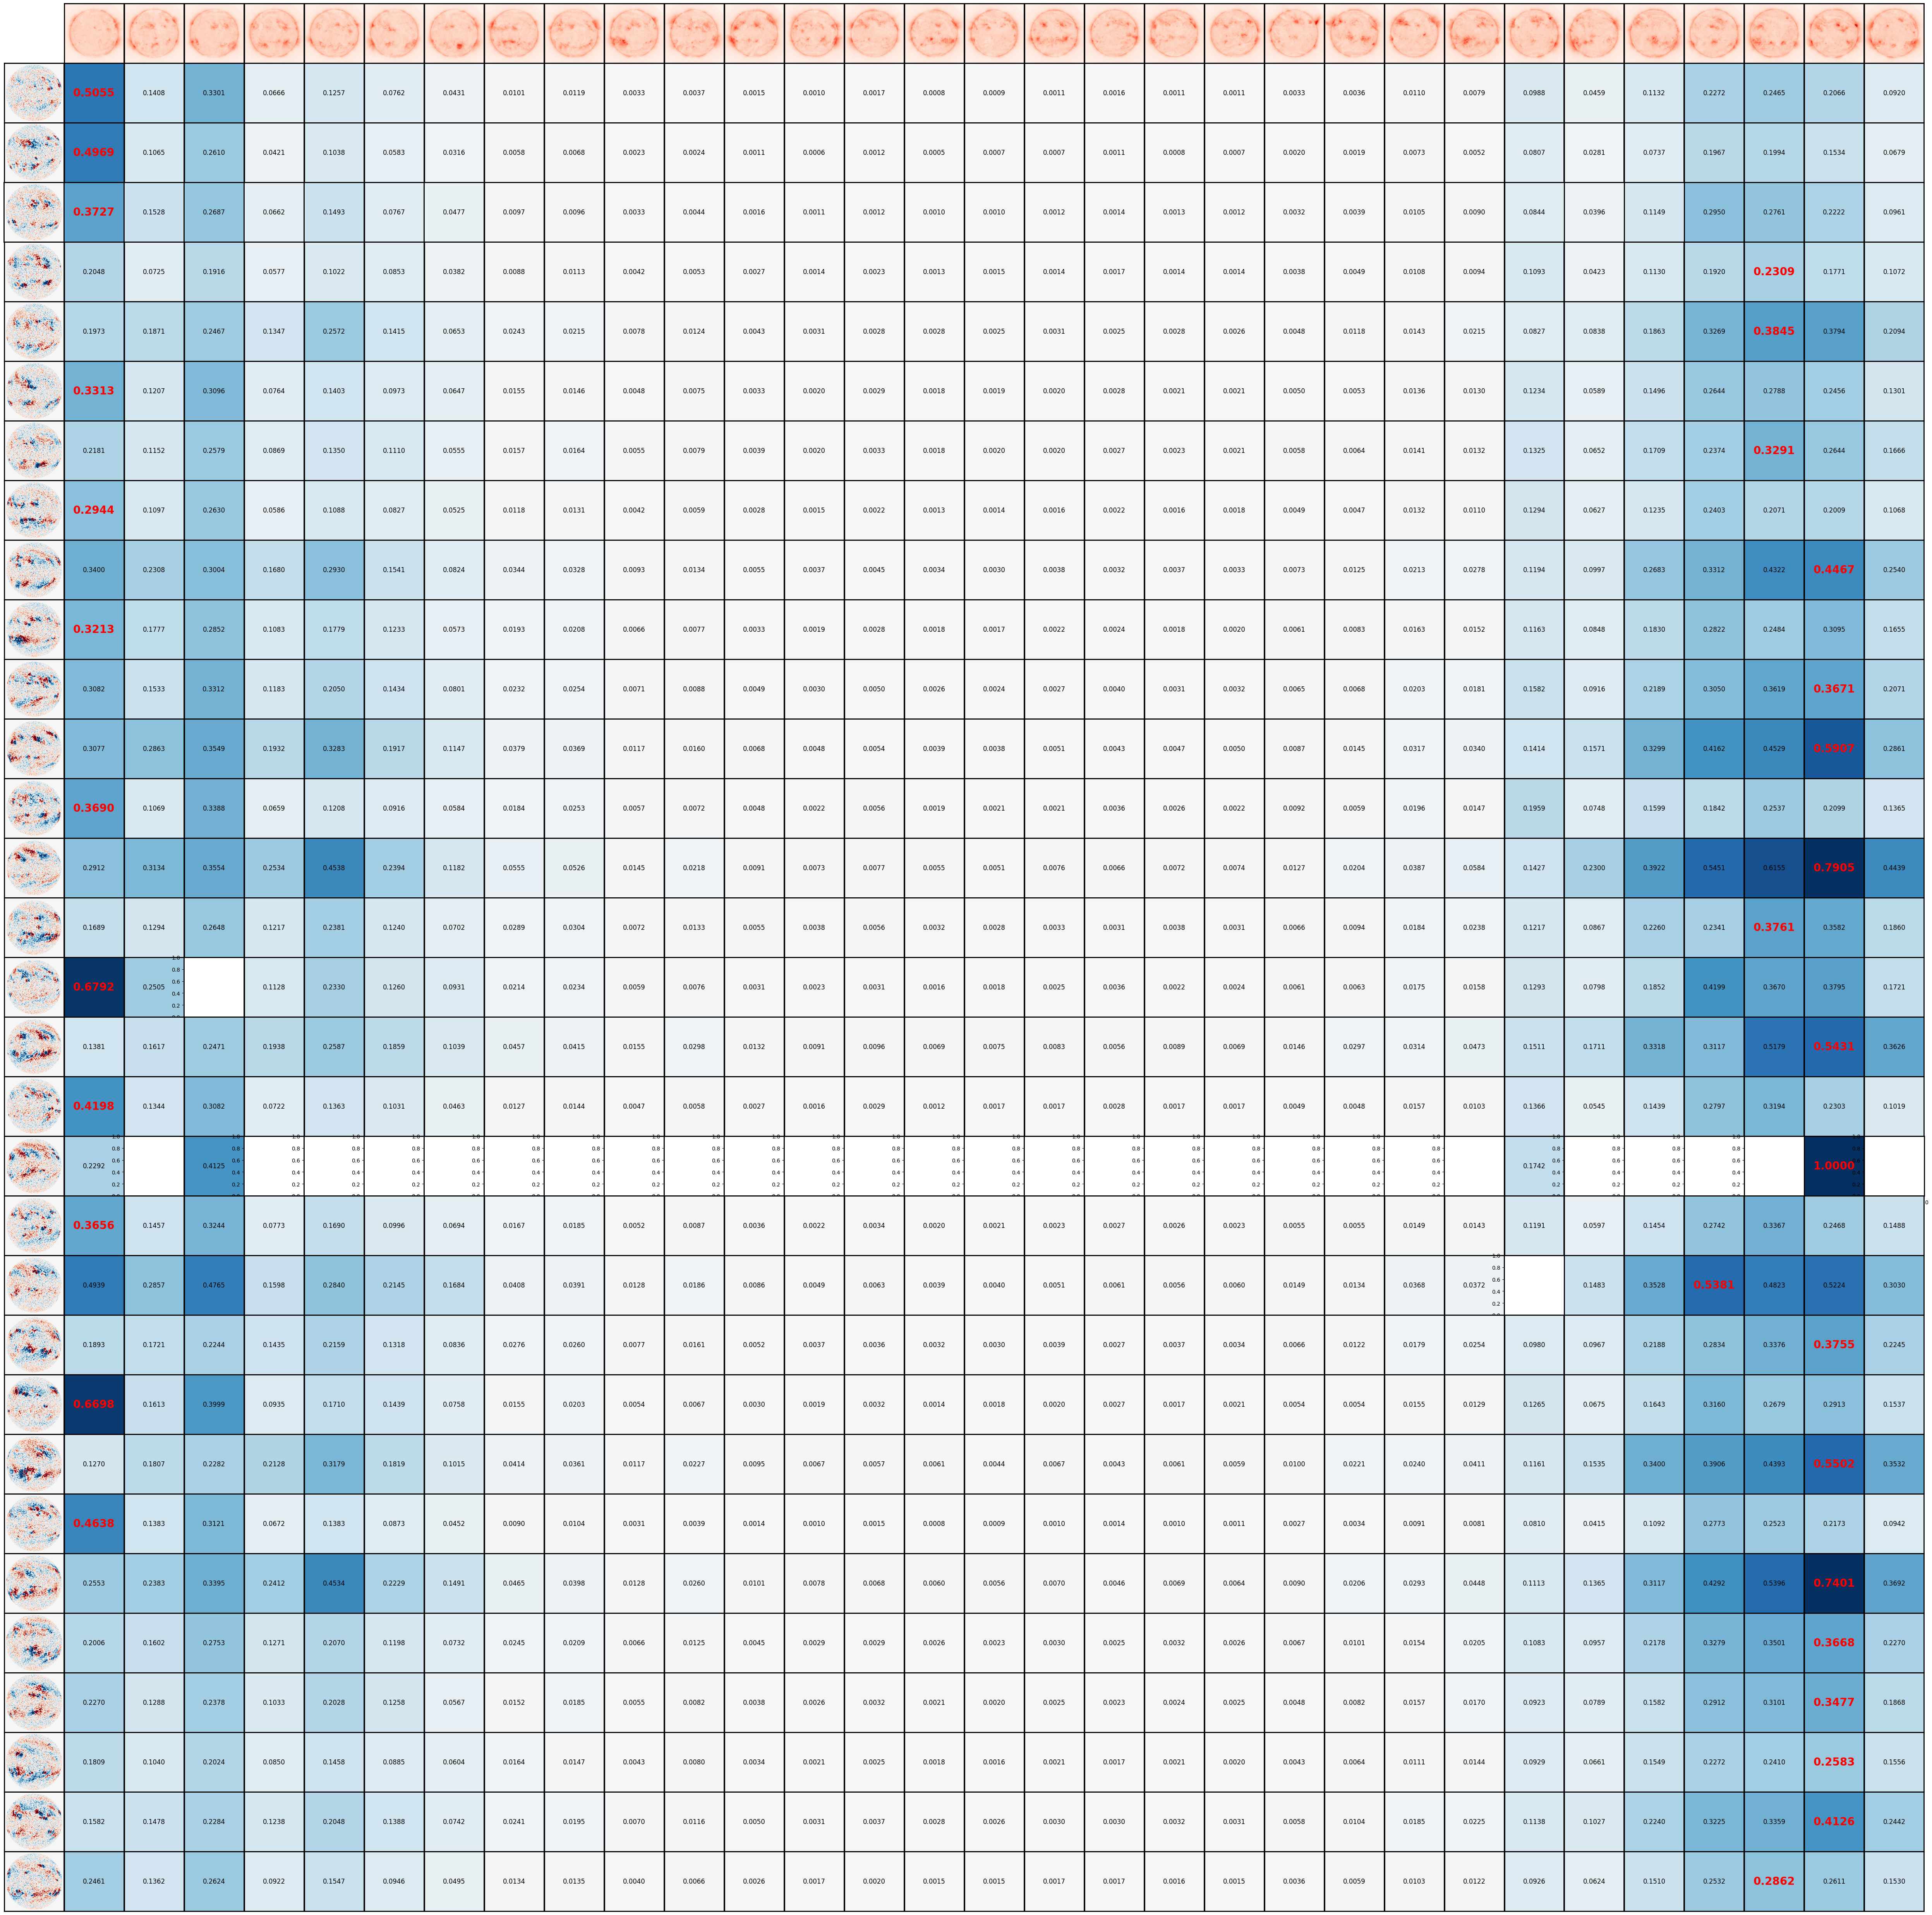

In [16]:
batch_id = 0
num_class = 31

# inner_loss_rate = args.inner_loss_rate

from Data.Solardataloader import transfer_log1p
print('acc mean:', np.mean(acc_list))
with torch.no_grad():
    for i, data in enumerate(val_loader):
        if i == batch_id:

            # mask = torch.arange(data.size(0)) != 11
            # data = data[mask]

            mag_image = data[:,0,:,:,:]
            h_image = data[:,1,:,:,:]
            data = data.to(device)
            loss, loss_inner, acc, logits_per_mag, inner_cor_matrix = calculate_loss(SolarModel, data, criterion=torch.nn.functional.cross_entropy)
            logits_per_mag = logits_per_mag/SolarModel.logit_scale.exp()
            logits_per_mag_np = logits_per_mag.cpu().numpy()
            # inner_cor_matrix = inner_cor_matrix.cpu().numpy()
            break
# vis_ids = np.random.choice(mag_image.shape[0], num_class, replace=False)
vis_ids = np.arange(num_class)
# vis_ids = vis_ids[vis_ids != 11]

mag_image = mag_image[vis_ids]
h_image = h_image[vis_ids]
mag_image = mag_image.cpu().numpy()
h_image = h_image.cpu().numpy()

mag_image = transfer_log1p(mag_image)
h_image = transfer_log1p(h_image)

logits_per_mag_np = logits_per_mag_np[vis_ids,:][:,vis_ids]
# inner_cor_matrix = inner_cor_matrix[vis_ids,:]
# print(mag_image.shape)

plot_matrix_with_images(logits_per_mag_np,inner_cor_matrix,mag_image,h_image)

#直接在plot_matrix_with_images中修改

images of different modals

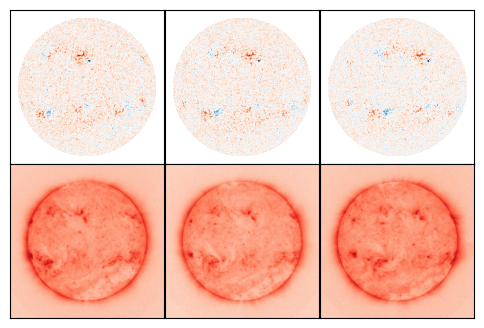

In [20]:
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from Data.Solardataloader import transfer_log1p

fig,ax = plt.subplots(2,3,figsize=(6,4))

for i in range(2,5):
    vmin = 0
    vmax = 10
    # path = f'/mnt/nas/home/zhouyuqing/downloads/AIA2013040{i}_0000_0335.fits'
    path = f'/mnt/nas/home/huxing/202407/nas/data/hmi/fits/hmi.M_720s.2010070{i}_150000_TAI.fits'
    img = fits.open(path)[1].data
    img = transfer_log1p(img)
    ax[0,i-2].imshow(img,cmap='RdBu_r')
    ax[0, i-2].set_xticks([])
    ax[0, i-2].set_yticks([])
    path = f'/mnt/nas/home/zhouyuqing/downloads/AIA2010070{i}_1000_0094.fits'
    img = fits.open(path)[1].data
    img = transfer_log1p(img)
    ax[1,i-2].imshow(img,cmap='Reds')
    ax[1, i-2].set_xticks([])
    ax[1, i-2].set_yticks([])

plt.subplots_adjust(wspace=0, hspace=0)


plt.show()
